In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

from pathlib import Path
import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
code_root = os.path.join(ipynb_dir, '..')
sys.path.append(code_root)  # Needed for import below

from sc2sensor.dataset import SensorCIFAR10
from sc2sensor.dataset import LABELS_DICT, DEFAULT_10
from sc2sensor.utils.image_utils import imshow


root = os.path.join(code_root, 'data') # Data root directory
subdir = 'starcraft-sensor-dataset'
model_root_dir = model_dir

IMAGE_SIZE = [3, 32, 32]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# FastAI demo of image segmentation

In [2]:
# Try out fastai code from https://docs.fast.ai/23_tutorial.vision.html
# Also seems really useful for PyTorch users: 
#  https://forums.fast.ai/t/using-pytorch-in-the-fastai-framework-a-guide/85770
from fastai.vision.all import *
path = untar_data(URLs.CAMVID_TINY, archive=os.path.join(root, 'archive'), data=root)
path.ls()

(#3) [Path('/local/scratch/a/dinouye/starcraft-dataset-extraction-private/paper-demos/../data/camvid_tiny/labels'),Path('/local/scratch/a/dinouye/starcraft-dataset-extraction-private/paper-demos/../data/camvid_tiny/codes.txt'),Path('/local/scratch/a/dinouye/starcraft-dataset-extraction-private/paper-demos/../data/camvid_tiny/images')]

In [3]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [4]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/local/scratch/a/dinouye/starcraft-dataset-extraction-private/paper-demos/../data/camvid_tiny/images/Seq05VD_f00480.png')

In [5]:
def label_func(fn): 
  return path/"labels"/f"{fn.stem}_P{fn.suffix}"
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames=fnames, label_func=label_func, codes=codes
)

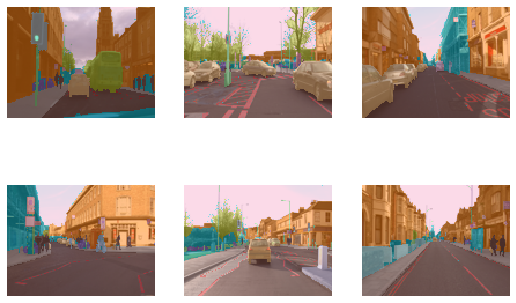

In [6]:
dls.show_batch(max_n=6)

In [7]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

epoch,train_loss,valid_loss,time
0,2.864784,2.533023,00:07


epoch,train_loss,valid_loss,time
0,1.804808,1.608983,00:02
1,1.540873,1.173416,00:02
2,1.365766,1.049307,00:02
3,1.232437,0.931956,00:02
4,1.122846,0.863416,00:02
5,1.030832,0.854338,00:02


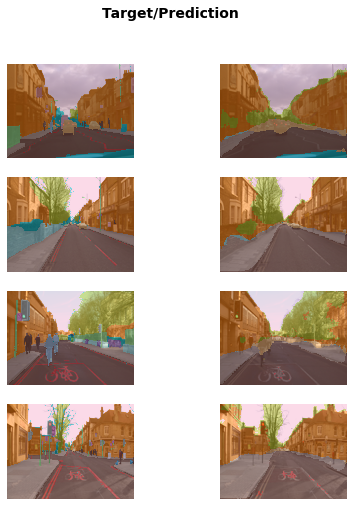

In [8]:
learn.show_results(max_n=4, figsize=(7,8))

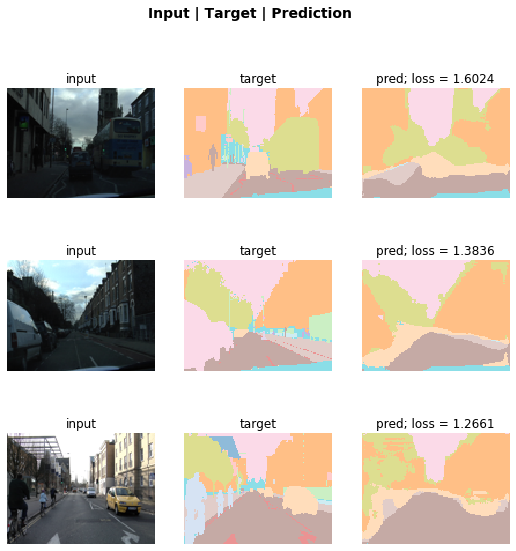

In [9]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [10]:
# Inspect format of input and output tensors for segmentation
batch = next(iter(next(iter(dls))))
print('Input:', batch[0].shape, type(batch[0]), batch[0].dtype)
print('Output:', batch[1].shape, type(batch[1]), batch[1].dtype)

Input: torch.Size([8, 3, 96, 128]) <class 'fastai.torch_core.TensorImage'> torch.float32
Output: torch.Size([8, 96, 128]) <class 'fastai.torch_core.TensorMask'> torch.int64


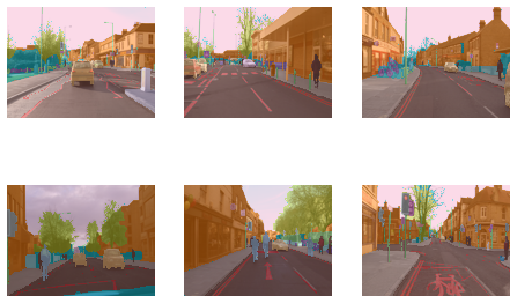

In [11]:
# Alternative using data_block data loader
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=None)
dls = camvid.dataloaders(path/"images", path=path, bs=8)
dls.show_batch(max_n=6)

In [12]:
from sc2sensor.dataset import StarCraftSensor

# Currently slow as it creates some extra columns I think
sc2_train = StarCraftSensor(root, subdir, train=True, use_sparse=False)
sc_sensor_dense = sc2_train
sc2_test = StarCraftSensor(root, subdir, train=False, use_sparse=False)

Using cached CSV metadata


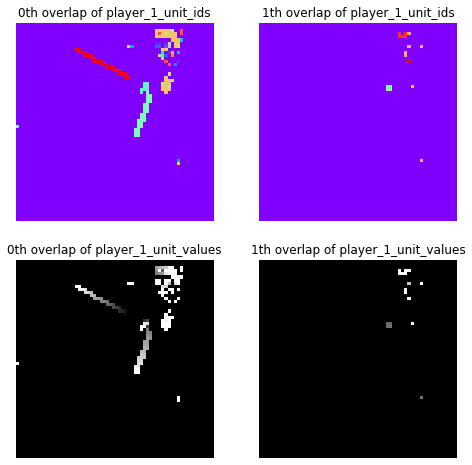

In [13]:
def show_channel(data, title, ax, imshow_kwargs=None):
    if imshow_kwargs is None:
        imshow_kwargs = dict(cmap='gray')
    ax.imshow(data, **imshow_kwargs)
    ax.grid(None)
    ax.set_axis_off()
    ax.set_title(title)
    
def display_dense(data_dict):
    row_keys = ['player_1_unit_ids', 'player_1_unit_values']
    n_row = len(row_keys)
    n_col = data_dict['player_1_unit_ids'].shape[0]
    fig, axes_mat = plt.subplots(n_row, n_col, figsize=[n_col*4, n_row*4] )
    for key, axes in zip(row_keys, axes_mat):
        data = data_dict[key]
        imshow_kwargs = None
        if key.endswith('ids'):
            # Make more interesting by creating unique ids
            data = np.unique(data, return_inverse=True)[1].reshape(data.shape)
            imshow_kwargs = dict(cmap='rainbow')
        for ii, (channel, ax) in enumerate(zip(data, axes)):
            show_channel(channel, f'{ii}th overlap of {key}', ax, imshow_kwargs=imshow_kwargs)
            
display_dense(sc_sensor_dense[-1])

In [14]:
temp_dict = sc_sensor_dense[-1]
temp_dict['player_1_unit_ids'].shape

torch.Size([2, 64, 64])

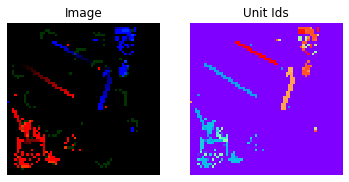

In [15]:
# Input: Max over both player tensor matrices for each spatial location
# Output: Most recent unit channel (i.e., id with the most recent time stamp, argmax over channel, 
#  then get the corresponding channel_id)
# Codes: nonneutral channel_to_unit_ids
# Could use data block and do get_x and get_y from a dataset object
# Easiest is probably to create a custom PyTorch dataset and use directly

#TODO: Use dataset getters + modifiers as get_x and get_y just using index...
def get_sc2_image_and_unit_ids(dataset, idx):
  data_dict = dataset[idx]
  
  # Argmax over all players to get max value and max unit ids
  def flatten(p):
    max_idx = torch.argmax(data_dict[f'{p}_unit_values'], dim=0, keepdim=True) # (1, 64, 64)
    max_values = torch.gather(data_dict[f'{p}_unit_values'], dim=0, index=max_idx)
    max_values2 = torch.max(data_dict[f'{p}_unit_values'], dim=0, keepdim=True)[0] # (1, 64, 64)
    assert torch.all(max_values==max_values2), 'Max not working as expected'
    max_unit_ids = torch.gather(data_dict[f'{p}_unit_ids'], dim=0, index=max_idx) # (1, 64, 64)
    return max_values, max_unit_ids
  
  players = ['player_2', 'neutral', 'player_1'] # To match RGB channels
  player_data = [flatten(p) for p in players]
  
  # Convert to color image
  image, mask = [
    torch.cat([
      (d[i]*0.2 if (p == 'neutral' and i == 0) else d[i])
      for p, d in zip(players, player_data)
    ], dim=0)
    for i in range(2)
  ]
  
  # Argmax both players to get single player unit ids over mask
  max_idx = torch.argmax(image[[0,2]], dim=0, keepdim=True) # (1, 64, 64)
  unit_ids = torch.gather(mask[[0,2]], dim=0, index=max_idx) # (1, 64, 64)
  return image, unit_ids


x, y = get_sc2_image_and_unit_ids(sc_sensor_dense, -1)
fig, axes = plt.subplots(1, 2)
show_channel(x.permute(1, 2, 0).type(torch.uint8), f'Image', ax=axes[0], imshow_kwargs=None)
y_recolored = np.unique(y, return_inverse=True)[1].reshape(y.shape)
show_channel(y_recolored.squeeze(0), f'Unit Ids', ax=axes[1], imshow_kwargs=dict(cmap='rainbow'))

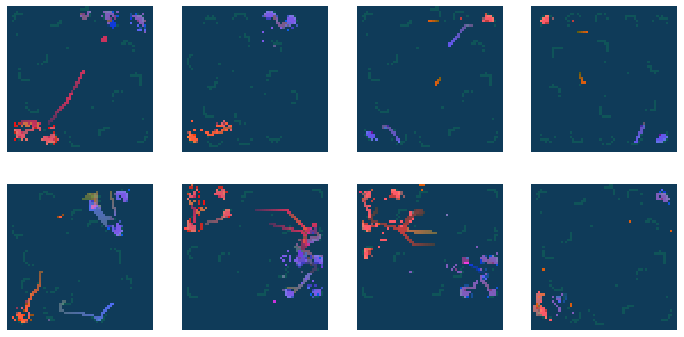

In [17]:
from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
sc2_codes = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]

sc2_hyper = DataBlock(
  blocks=(ImageBlock, MaskBlock(codes=sc2_codes)),
  #get_items=lambda dataset: [i for i in range(len(dataset))],
  get_items=lambda dataset: [i for i in range(1000)],
  get_x=lambda idx: get_sc2_image_and_unit_ids(sc_sensor_dense, idx)[0].permute(1, 2, 0).type(torch.uint8).numpy(),
  get_y=lambda idx: get_sc2_image_and_unit_ids(sc_sensor_dense, idx)[1].squeeze(0).type(torch.uint8).numpy(),
  splitter=RandomSplitter(seed=0),
  batch_tfms=None)

dls = sc2_hyper.dataloaders(sc_sensor_dense, shuffle=False, bs=8)
dls.show_batch(max_n=8)

In [18]:
learn = unet_learner(dls, resnet34)

In [19]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,time
0,0.413998,0.198195,00:07


epoch,train_loss,valid_loss,time
0,0.181901,0.175481,00:08
1,0.162996,0.155523,00:08
2,0.149756,0.149396,00:07
3,0.140464,0.144323,00:08
4,0.132098,0.138738,00:08
5,0.124780,0.135525,00:08


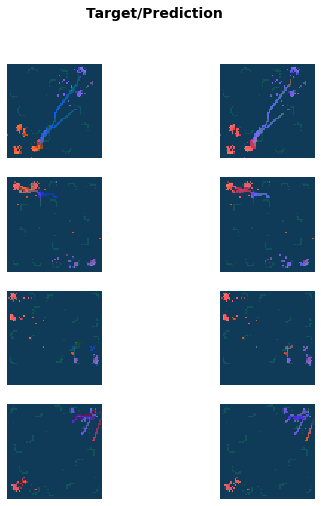

In [20]:
learn.show_results(max_n=4, figsize=(7,8))

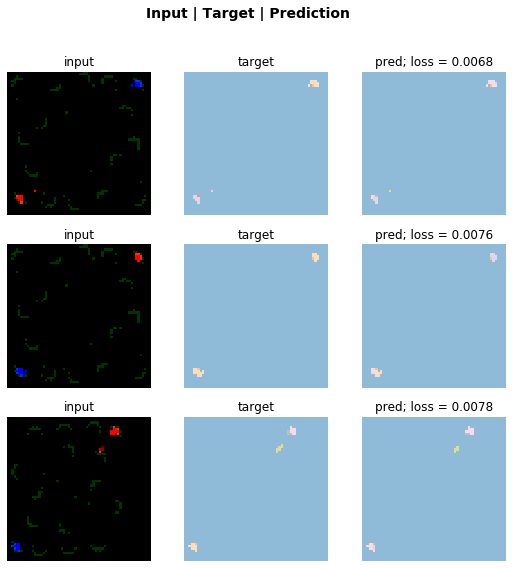

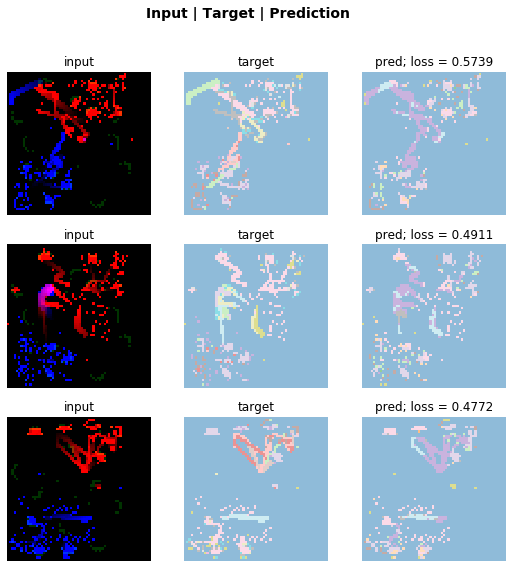

In [21]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3, largest=False)
interp.plot_top_losses(k=3, largest=True)

In [22]:
# Currently slow as it creates some extra columns I think
sc2_train = StarCraftSensor(root, subdir, train=True, use_sparse=False)
sc2_test = StarCraftSensor(root, subdir, train=False, use_sparse=False)
# Note it is filtered 90% 10% by *matches* so not exactly 90-10 split for num of windows
print(len(sc2_train)) 
print(len(sc2_test))

Using cached CSV metadata
Using cached CSV metadata
1252866
138465


In [59]:
%pdb on
import PIL
# Setup directories
data_root = root
starcraft_segment_dir = os.path.join(data_root, subdir, 'starcraft_segment')
train_test = [os.path.join(starcraft_segment_dir, 'train'), os.path.join(starcraft_segment_dir, 'test')]
image_dirs = [os.path.join(f, 'images') for f in train_test]
label_dirs = [os.path.join(f, 'labels') for f in train_test]
for d in [starcraft_segment_dir, *train_test, *image_dirs, *label_dirs]:
  if not os.path.exists(d):
    os.mkdir(d)
    
# Save the dataset as PNG images
MAX_PER_CHUNK = 10000 # To avoid 65536 cap for 32 bit systems
from tqdm.notebook import tqdm
for dataset, image_dir, label_dir in tqdm(zip([sc2_train, sc2_test], image_dirs, label_dirs), total=2, desc='Datasets'):
  idx = 0
  n_chunks = int(torch.tensor(len(dataset)/MAX_PER_CHUNK).ceil())
  for chunk_idx in tqdm(range(n_chunks), desc='Chunks'):
    chunk_image_dir = os.path.join(image_dir, f'{chunk_idx:02d}')
    chunk_label_dir = os.path.join(label_dir, f'{chunk_idx:02d}')
    for d in [chunk_image_dir, chunk_label_dir]:
      if not os.path.exists(d):
        os.mkdir(d)
    
    for _ in tqdm(range(MAX_PER_CHUNK), desc='Windows'):
      # Get replay and frame number for filename
      frame_idx = dataset.metadata.iloc[idx]['dynamic.frame_idx']
      replay_name = os.path.splitext(dataset.metadata.iloc[idx]['static.replay_name'])[0]

      # Construct filenames
      image_filename = os.path.join(chunk_image_dir, f'{replay_name}_{frame_idx}.png')
      label_filename = os.path.join(chunk_label_dir, f'{replay_name}_{frame_idx}_labels.png')
      
      # Only create if does not exist yet
      if not os.path.exists(image_filename):
        # Get data
        image, labels = get_sc2_image_and_unit_ids(dataset, idx)

        # Convert to PIL images
        # needs to be in (H, W, C) and uint8
        pil_image = PIL.Image.fromarray(image.permute(1, 2, 0).type(torch.uint8).numpy())
        labels_arr = labels.permute(1, 2, 0).type(torch.uint8).numpy()
        pil_labels = PIL.Image.fromarray(labels.squeeze(0).type(torch.uint8).numpy())

        # Save data as PNG files
        pil_image.save(image_filename)
        pil_labels.save(label_filename)

        idx += 1
      #break # 1 image
    #break # 1 chunk
PIL.Image.open(image_filename)

Automatic pdb calling has been turned ON


Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Chunks:   0%|          | 0/126 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

> /local/scratch/a/dinouye/miniconda3/envs/starcraft/lib/python3.7/site-packages/pandas/core/dtypes/common.py(388)is_timedelta64_dtype()
    386 
    387 
--> 388 def is_timedelta64_dtype(arr_or_dtype) -> bool:
    389     """
    390     Check whether an array-like or dtype is of the timedelta64 dtype.

ipdb> quit


In [29]:
sc2_train.metadata

,Unnamed: 0,dynamic.date_time_format,dynamic.date_time_str,dynamic.frame_idx,dynamic.num_windows,dynamic.timestamp,dynamic.window_idx,dynamic.window_percent,static.extracted_image_size,static.game_info.map_name,...,static.replay_info.player_stats.player_1.mmr,static.replay_info.player_stats.player_1.result,static.replay_info.player_stats.player_1.result_int,static.replay_info.player_stats.player_2.apm,static.replay_info.player_stats.player_2.mmr,static.replay_info.player_stats.player_2.result,static.replay_info.player_stats.player_2.result_int,static.replay_name,computed.target_label,computed.target_id
0,1349386,%Y-%m-%d_%H-%M-%S,2022-06-07_15-02-42,8488,61,1.654629e+09,32,0.524590,"[64, 64]",Ascension to Aiur LE,...,2879,Win,1,124,0,Loss,2,a1fdaab55614a0a24340c2c8c47fb5d54f6512fc2c79781d44f142063c012b5f.SC2Replay,"(Ascension to Aiur LE, End)",5
1,1105590,%Y-%m-%d_%H-%M-%S,2022-06-07_16-39-41,17411,75,1.654634e+09,67,0.893333,"[64, 64]",Ascension to Aiur LE,...,3282,Loss,2,121,3266,Win,1,a59b40d50089a07b431833bb8c0e00a3fe503b270ca9c9087a04b099a0916088.SC2Replay,"(Ascension to Aiur LE, End)",5
2,1714296,%Y-%m-%d_%H-%M-%S,2022-06-08_06-18-33,14074,57,1.654684e+09,54,0.947368,"[64, 64]",Abyssal Reef LE,...,0,Win,1,71,0,Loss,2,2554f40add475d58b1546388e86dd89dc974685be9ef05bd612a1b2d6a31282f.SC2Replay,"(Abyssal Reef LE, End)",3
3,1833932,%Y-%m-%d_%H-%M-%S,2022-06-08_13-27-53,9925,107,1.654709e+09,37,0.345794,"[64, 64]",Ascension to Aiur LE,...,3509,Win,1,95,3404,Loss,2,b19ad53ef3dff522cc739ddeaa7cd54cc9b2b3d86ea81e44690d1d78ae953ddf.SC2Replay,"(Ascension to Aiur LE, Beginning)",4
4,1314138,%Y-%m-%d_%H-%M-%S,2022-06-07_11-15-12,832,86,1.654615e+09,2,0.023256,"[64, 64]",Odyssey LE,...,3275,Loss,2,179,3340,Win,1,326709248148da9801239a59098c90cbf2fa7f5c5768982414f526a3752ae125.SC2Replay,"(Odyssey LE, Beginning)",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252861,1385718,%Y-%m-%d_%H-%M-%S,2022-06-07_05-39-32,2488,77,1.654595e+09,8,0.103896,"[64, 64]",Abyssal Reef LE,...,3834,Loss,2,193,3842,Win,1,a561aa94b20e3f24697af625bc1ade9e801d1f0d5e41ac664dc8b11df2172f6c.SC2Replay,"(Abyssal Reef LE, Beginning)",2
1252862,157484,%Y-%m-%d_%H-%M-%S,2022-06-07_18-11-31,37687,156,1.654640e+09,146,0.935897,"[64, 64]",Ascension to Aiur LE,...,4213,Win,1,90,4095,Loss,2,833729afee1b5681feab9d58a481e648398ba13634f016dadff9ef12ed1e9182.SC2Replay,"(Ascension to Aiur LE, End)",5
1252863,1578121,%Y-%m-%d_%H-%M-%S,2022-06-08_16-08-45,14989,109,1.654719e+09,57,0.522936,"[64, 64]",Mech Depot LE,...,3508,Win,1,137,3571,Loss,2,b82d599377c64112b7461274014ccd9ea53895b2277bd78a12afe5baf426511f.SC2Replay,"(Mech Depot LE, End)",7
1252864,1539253,%Y-%m-%d_%H-%M-%S,2022-06-07_01-44-07,12543,102,1.654581e+09,48,0.470588,"[64, 64]",Ascension to Aiur LE,...,1988,Loss,2,111,2341,Win,1,1e85f299e17f080c58607905c9a32cc9da3c0efc99cc44c501858e6b703b1ed0.SC2Replay,"(Ascension to Aiur LE, Beginning)",4
